# Fine-Tuning Our Recession Prediction Features

Now that we've got a working model, let's optimize it! We'll experiment with different feature engineering approaches to squeeze out every bit of predictive power we can get from our economic data.

**What we'll try:**
- Test different lag periods for consumer sentiment (how far back should we look?)
- Create interaction terms between sentiment and economic indicators
- Transform sentiment data in various ways to capture different patterns
- Use feature selection to find the cream of the crop
- Compare models with and without sentiment to prove its value

In [1]:
# Import notebook utilities
from notebook_utils import init_notebook, load_data, display_data_info, save_figure
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Initialize notebook environment
init_notebook()

# Import from econ_downturn package
from econ_downturn import (
    engineer_features, normalize_data, apply_mda, create_discriminant_time_series,
    plot_indicator_with_recessions, plot_correlation_matrix,
    plot_feature_importance, plot_discriminant_time_series,
    
    # Advanced feature engineering functions
    engineer_features_with_custom_lags, create_interaction_terms,
    apply_sentiment_transformations, select_features
)

Initializing notebook environment...
✓ Added c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\src to Python path
✓ econ_downturn package imported successfully
✓ Notebook environment configured
✓ Environment variables loaded

Available data paths:
  fred_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred
  nber_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\nber
  processed_dir: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed
  fred_all_indicators: c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\fred\all_indicators.csv
  nber_recession_indicator: c:\Users\Admin\e

## Getting Our Data Ready

Let's start by loading all our data sources and getting everything set up for our optimization experiments.

In [2]:
# Load all data using the utility function
merged_data = load_data(use_cached=False)  # Force reload from original sources

# Display information about the dataset
display_data_info(merged_data)

Loading data from original sources...
2025-07-06 13:43:27,169 - econ_downturn.data.data_loader - INFO - Loaded FRED data with shape: (15510, 10)
2025-07-06 13:43:27,173 - econ_downturn.data.data_loader - INFO - Loaded NBER recession data with shape: (653, 1)
2025-07-06 13:43:27,176 - econ_downturn.data.data_loader - INFO - Loaded UMich data with shape: (653, 2)
2025-07-06 13:43:27,177 - econ_downturn.data.data_loader - INFO - Initialized merged dataset with 'FRED' data
2025-07-06 13:43:27,180 - econ_downturn.data.data_loader - INFO - Added 'NBER' data to merged dataset
2025-07-06 13:43:27,189 - econ_downturn.data.data_loader - INFO - Added 'UMICH' data to merged dataset
2025-07-06 13:43:27,190 - econ_downturn.data.data_loader - INFO - Merged dataset shape: (15657, 13)
2025-07-06 13:43:27,268 - econ_downturn.data.data_loader - INFO - Saved merged dataset to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\

,GDP,UNEMPLOYMENT,CPI,FED_FUNDS,YIELD_CURVE,INITIAL_CLAIMS,INDUSTRIAL_PROD,RETAIL_SALES,HOUSING_STARTS,CONSUMER_SENTIMENT,recession,SENTIMENT,INFLATION_EXPECTATION
count,218.000000,653.000000,653.000000,653.000000,11998.000000,2.839000e+03,653.000000,389.000000,653.000000,589.000000,653.000000,589.000000,557.000000
mean,12837.776711,6.110260,158.663954,4.910490,0.868401,3.733381e+05,74.982246,365237.385604,1435.917305,84.583531,0.128637,84.583531,3.590126
std,5217.489014,1.709394,73.783619,3.898737,0.925610,2.450608e+05,22.585732,138188.557313,410.165486,13.111529,0.335054,13.111529,1.625392
min,5299.672000,3.400000,37.900000,0.050000,-2.410000,1.890000e+05,36.388100,158647.000000,478.000000,50.000000,0.000000,50.000000,0.400000
25%,7760.008000,4.900000,100.100000,1.510000,0.190000,3.010000e+05,51.806000,264067.000000,1176.000000,74.300000,0.000000,74.300000,2.800000
50%,12216.346500,5.800000,159.800000,5.050000,0.830000,3.460000e+05,78.919700,349869.000000,1465.000000,88.200000,0.000000,88.200000,3.000000
75%,16937.626250,7.200000,219.035000,6.890000,1.500000,4.020000e+05,97.606000,443117.000000,1698.000000,94.200000,0.000000,94.200000,3.500000
max,23223.906000,14.800000,313.140000,19.100000,2.910000,6.137000e+06,104.103800,692635.000000,2494.000000,112.000000,1.000000,112.000000,10.400000



Missing Values:


,Missing Values,Percentage
GDP,15439,98.607652
RETAIL_SALES,15268,97.515488
INFLATION_EXPECTATION,15100,96.442486
SENTIMENT,15068,96.238104
CONSUMER_SENTIMENT,15068,96.238104
INDUSTRIAL_PROD,15004,95.829342
FED_FUNDS,15004,95.829342
CPI,15004,95.829342
UNEMPLOYMENT,15004,95.829342
recession,15004,95.829342


## Experimenting with Sentiment Lag Periods

This step will explore how far back in time consumer sentiment data will remain useful for predicting recession. This step will help us test our hypothesis that longer-term sentiment patterns could give strong early signals of recession.

1. First we generate our lagged sentiment features using engineer_features_with_custom_lags(). This adds lagged versions of the sentiment column (e.g., 1, 3, 6, 12, 18, and 24 months) to capture any delayed effects.

2. Now we combine these lagged features into a master dataset. We will create a new DataFrame that includes all the original indicators plus the lag features for both sentiment and macroeconomic variables.

3. This master dataset is saved for later re-use.

In [3]:
# Engineer features with different lag periods for consumer sentiment
data_with_custom_lags = engineer_features_with_custom_lags(
    merged_data,
    sentiment_lags=[1, 3, 6, 12, 18, 24],
    other_lags=[1, 3, 6, 12]
)

# Save the dataset with custom lags
from econ_downturn import get_data_paths
data_paths = get_data_paths()
output_dir = data_paths['processed_dir']
os.makedirs(output_dir, exist_ok=True)
custom_lags_path = os.path.join(output_dir, 'data_with_custom_sentiment_lags.csv')
data_with_custom_lags.to_csv(custom_lags_path)
print(f"Saved dataset with custom lags to {custom_lags_path}")

Resampled data to M frequency, new shape: (653, 13)
Created lag variables, new shape: (653, 113)
Calculated rate of change, new shape: (653, 449)
Dropped rows with missing values, new shape: (581, 449)
Saved dataset with custom lags to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\data_with_custom_sentiment_lags.csv


## Building Interaction Features

We will further enhance our dataset by adding combined signals between our sentiment and economic indicators. This helps build model effectiveness by letting it learn the patterns from combinations of variables, not simple indidivual metrics.

The create_interaction_terms() multiplies sentiment columns with our economic indicators to create features that reflect how two variables behave jointly.

In [4]:
# Create interaction terms
data_with_interactions = create_interaction_terms(data_with_custom_lags)

# Save the dataset with interaction terms
interactions_path = os.path.join(output_dir, 'data_with_interactions.csv')
data_with_interactions.to_csv(interactions_path)
print(f"Saved dataset with interaction terms to {interactions_path}")

Created interaction terms, new shape: (581, 461)
Saved dataset with interaction terms to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\data_with_interactions.csv


## Transforming Sentiment Data

In this step, we experiment with mathematically transforming sentiment to see if there are deeper patterns. The transformations we apply enhance the model's sensitivity to how sentiment changes over time. There are a couple key steps for this code:

1. We use the apply_sentiment_transformations(), which modifies the sentiment column using operations like squaring, percentage change, or rolling averages.

2. These transofmations help the model to spot subtle changes (share drops, consistent declines) that raw sentiment values may omit.

In [5]:
# Apply transformations to sentiment data
data_with_transformations = apply_sentiment_transformations(data_with_interactions)

# Save the dataset with transformations
transformations_path = os.path.join(output_dir, 'data_with_transformations.csv')
data_with_transformations.to_csv(transformations_path)
print(f"Saved dataset with transformations to {transformations_path}")

Applied transformations to sentiment data, new shape: (581, 472)
Saved dataset with transformations to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\data\processed\data_with_transformations.csv


## Finding the Best Features

This step is geared toward narrowing down the massive feature set we have with two proven techniques from our utility package: ANOVA and RFE. With these two approaches, we are testing whether statistical relevance (ANOVA) or iterative model-based selection (RFE) yields better predictors.

1. First, we normalize our data using the previously explained normalize_data() package. This ensures large numerical ranges don't dominate.

2. Next, select_features() is called with 'anova' passed into the method argument. This ranks features based on their statistical correlation with the recessional label and keeps only the top 20.

3. The same utility function is then rerun with 'rfe' passed into the method argument. This repeatedly removes the least important features based on model performance, keeping the top 20 again.

In [6]:
# Normalize the data
data_normalized, _ = normalize_data(data_with_transformations)

# Separate features and target
X = data_normalized.drop(columns=['recession'])
y = data_normalized['recession']

# Select features using ANOVA F-value
X_selected_anova, selected_features_anova = select_features(X, y, method='anova', k=20)

# Select features using Recursive Feature Elimination
X_selected_rfe, selected_features_rfe = select_features(X, y, method='rfe', k=20)

2025-07-06 13:43:28,408 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (581, 472)
Selected 20 features using ANOVA F-value
Top 10 selected features:
                       Feature       Score
456  SENTIMENT_minus_FED_FUNDS  180.895685
138       HOUSING_STARTS_roc12  165.650774
114                  GDP_roc12  164.879430
131       INDUSTRIAL_PROD_roc3  164.675262
282  HOUSING_STARTS_lag1_roc12  162.362905
460              SENTIMENT_log  145.398877
461             SENTIMENT_sqrt  139.573290
463           SENTIMENT_zscore  133.223422
10                   SENTIMENT  133.223422
9           CONSUMER_SENTIMENT  133.223422

All top 10 features (selected and non-selected):
                       Feature       Score  Selected
456  SENTIMENT_minus_FED_FUNDS  180.895685      True
138       HOUSING_STARTS_roc12  165.650774      True
114                  GDP_roc12  164.879430      True
131       INDUSTRIAL_PROD_roc3  164.675262      True
282  HOUSING_STA

## The Sentiment Showdown

In this step, we will directly compare our model's performance with and without sentiment features to test their true value in prediction. This process is handled singularly by the compare_mda_models() function.

1. First, we prep our data by creating a copy of the input dataset. We set with_sentiment=False to drop all features containing 'SENTIMENT'. This allows us to test our model's baseline performance without sentiment influence.

2. The dataset is normaled using our normalize_data() function and split into featurs X and target y (recessionary periods). apply_mda() is called to train and evaluate our MDA model.

3. To visualize our results, we generate a bar chart using plot_feature_importance(). Additionally, we create a time-series of the model's discriminant output usingcreate_discriminant_time_series() and plot it using plot_discriminant_time_series().

This entire setup runs twice: once with our sentiment data and once without. This allows a side-by-side comparison of predictive performance.


MDA Model WITH Sentiment Features:
2025-07-06 13:43:32,703 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (581, 472)
2025-07-06 13:43:32,707 - econ_downturn.models.mda - INFO - Training set shape: (406, 471), Testing set shape: (175, 471)
2025-07-06 13:43:32,769 - econ_downturn.models.mda - INFO - Accuracy: 0.9086
2025-07-06 13:43:32,770 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[143  11]
 [  5  16]]
2025-07-06 13:43:32,770 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95       154
         1.0       0.59      0.76      0.67        21

    accuracy                           0.91       175
   macro avg       0.78      0.85      0.81       175
weighted avg       0.92      0.91      0.91       175

2025-07-06 13:43:33,086 - econ_downturn.models.mda - INFO - Cross-Validation Scores: [0.94017094 0.9137931  0.92241379 0.9568

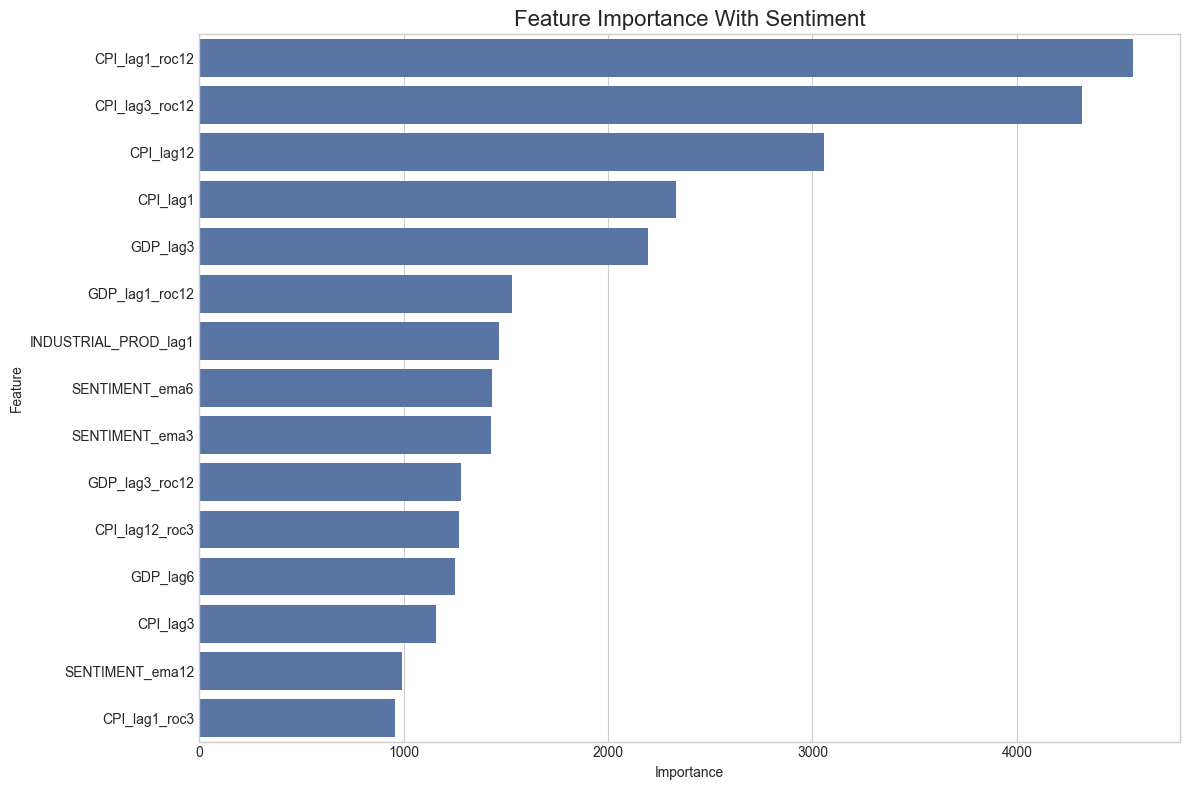

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\feature_importance_with_sentiment.png


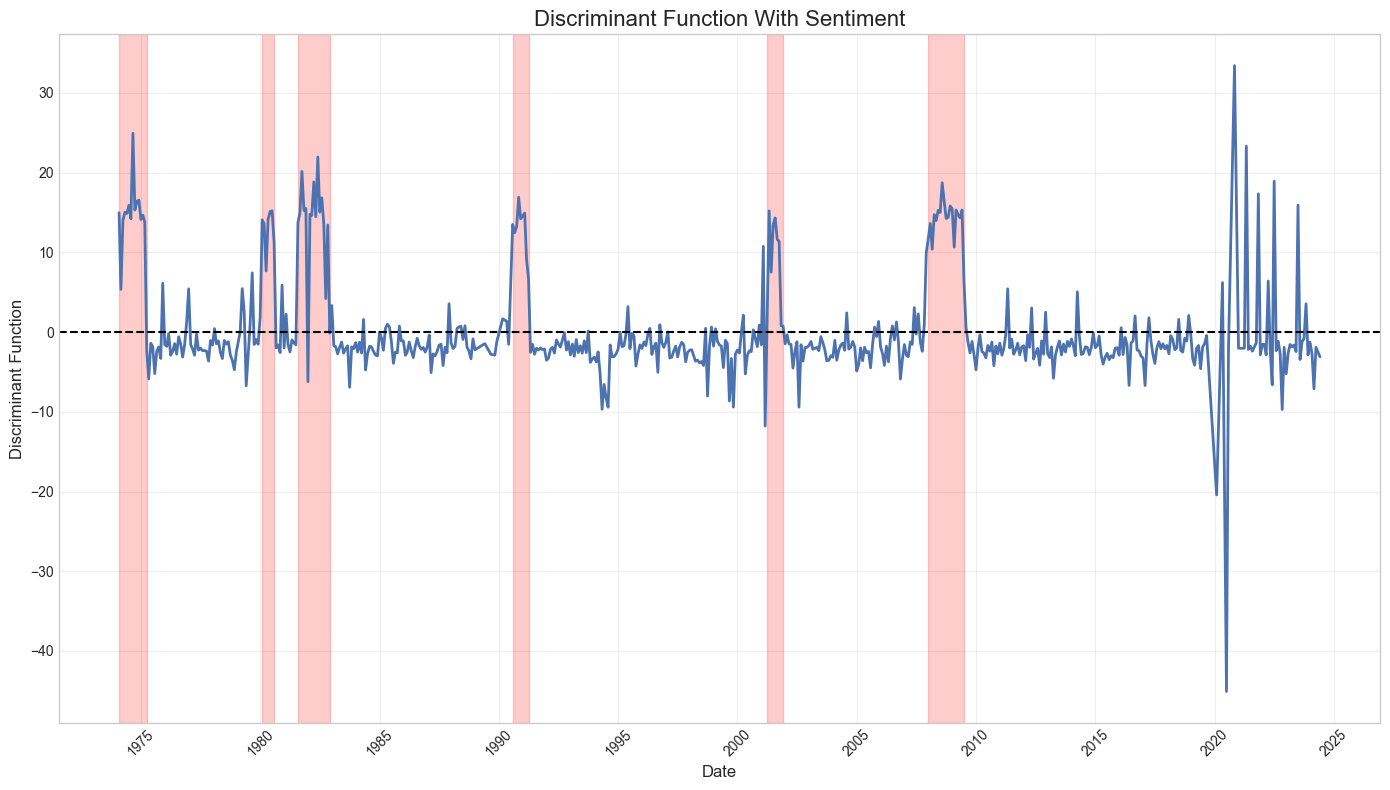

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\discriminant_time_series_with_sentiment.png

MDA Model WITHOUT Sentiment Features:
Removed 271 sentiment-related features
2025-07-06 13:43:33,734 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (581, 201)
2025-07-06 13:43:33,740 - econ_downturn.models.mda - INFO - Training set shape: (406, 200), Testing set shape: (175, 200)
2025-07-06 13:43:33,813 - econ_downturn.models.mda - INFO - Accuracy: 0.9543
2025-07-06 13:43:33,814 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[148   6]
 [  2  19]]
2025-07-06 13:43:33,815 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       154
         1.0       0.76      0.90      0.83        21

    accuracy                           0.95     

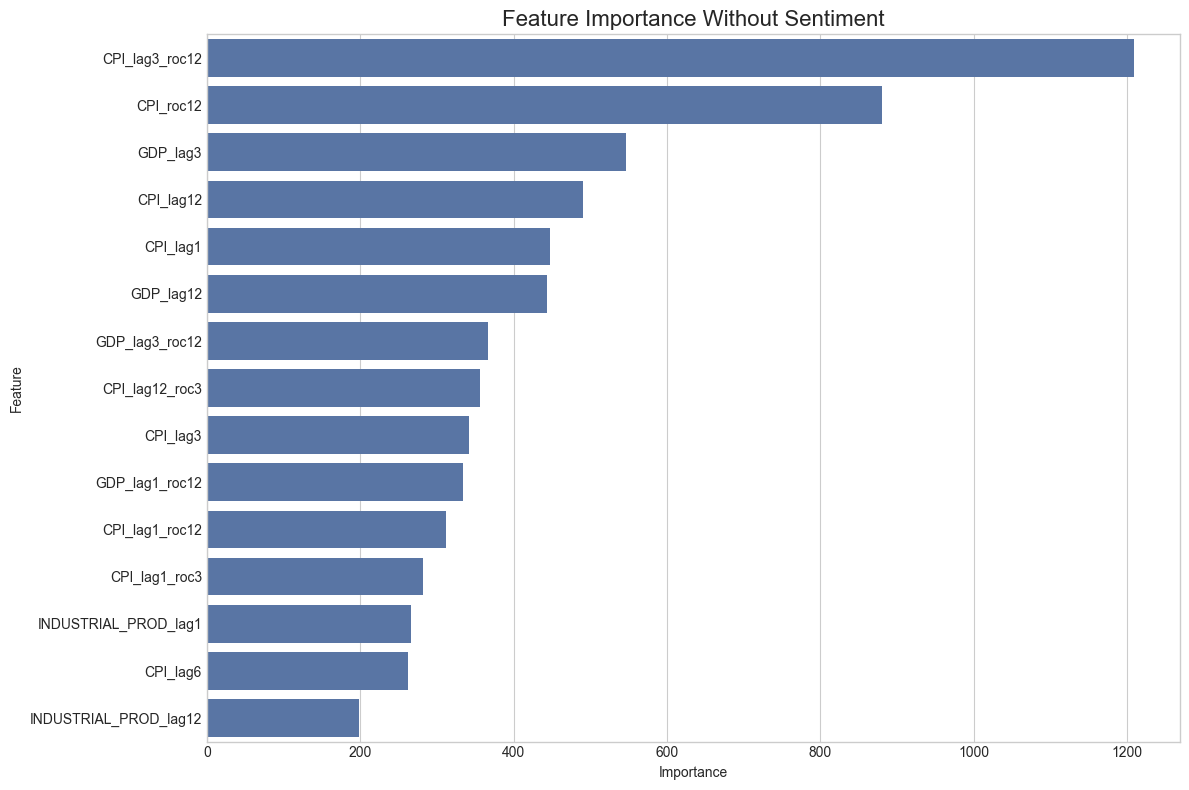

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\feature_importance_without_sentiment.png


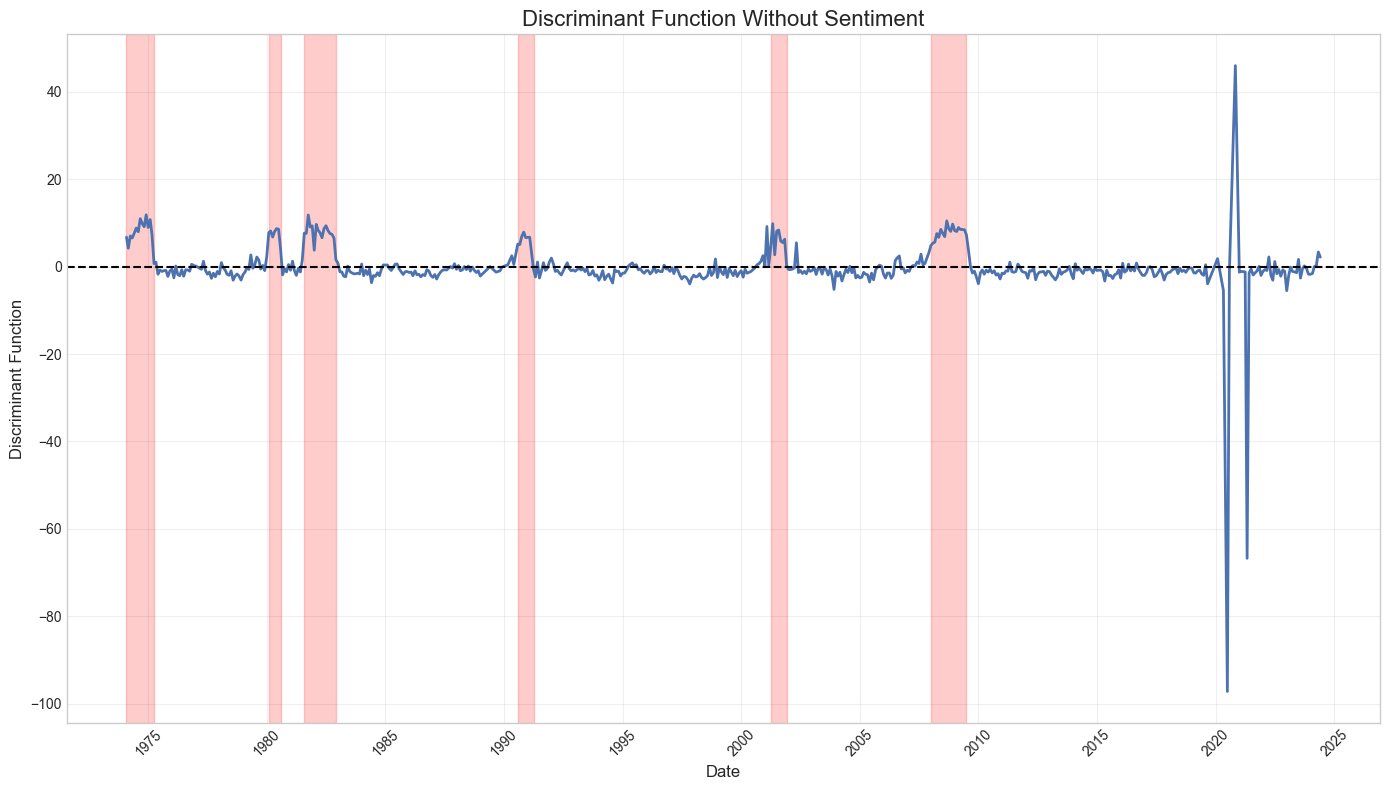

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\discriminant_time_series_without_sentiment.png


In [7]:
def compare_mda_models(data, with_sentiment=True):
    """
    Compare MDA models with and without consumer sentiment features.
    
    Parameters
    ----------
    data : pandas.DataFrame
        Input dataset
    with_sentiment : bool
        Whether to include sentiment features
        
    Returns
    -------
    dict
        MDA results
    """
    # Make a copy of the data
    df = data.copy()
    
    # Identify sentiment-related columns
    sentiment_cols = [col for col in df.columns if 'SENTIMENT' in col]
    
    # Remove sentiment features if not including them
    if not with_sentiment:
        df = df.drop(columns=sentiment_cols)
        print(f"Removed {len(sentiment_cols)} sentiment-related features")
    
    # Normalize the data
    df_normalized, _ = normalize_data(df)
    
    # Separate features and target
    X = df_normalized.drop(columns=['recession'])
    y = df_normalized['recession']
    
    # Apply MDA
    mda_results = apply_mda(X, y)
    
    # Print model performance metrics
    print(f"Accuracy: {mda_results['accuracy']:.4f}")
    print("\nConfusion Matrix:")
    print(mda_results['conf_matrix'])
    print("\nClassification Report:")
    print(mda_results['class_report'])
    print(f"\nCross-Validation Scores: {mda_results['cv_scores']}")
    print(f"Mean CV Score: {mda_results['cv_scores'].mean():.4f}")
    
    # Plot feature importances
    if mda_results['feature_importance'] is not None:
        fig = plot_feature_importance(mda_results['feature_importance'])
        plt.title(f"Feature Importance {'With' if with_sentiment else 'Without'} Sentiment", fontsize=16)
        plt.show()
        save_figure(fig, f"feature_importance_{'with' if with_sentiment else 'without'}_sentiment.png")
    
    # Create and plot discriminant time series
    discriminant_df = create_discriminant_time_series(mda_results['model'], X, y)
    fig = plot_discriminant_time_series(discriminant_df)
    plt.title(f"Discriminant Function {'With' if with_sentiment else 'Without'} Sentiment", fontsize=16)
    plt.show()
    save_figure(fig, f"discriminant_time_series_{'with' if with_sentiment else 'without'}_sentiment.png")
    
    return mda_results

# Compare MDA models with and without sentiment features
print("\nMDA Model WITH Sentiment Features:")
mda_with_sentiment = compare_mda_models(data_with_transformations, with_sentiment=True)

print("\nMDA Model WITHOUT Sentiment Features:")
mda_without_sentiment = compare_mda_models(data_with_transformations, with_sentiment=False)

## Testing Our Selected Features

Lastly, this section test whether picking only the most relevant features materially improved our model accuracy. We will apply MDA seperately to the top 20 features chosen by ANOVA and RFE (Recursive Feature Elimination), then compare results.


MDA Model with ANOVA-Selected Features:
2025-07-06 13:43:34,999 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (581, 21)
2025-07-06 13:43:35,004 - econ_downturn.models.mda - INFO - Training set shape: (406, 20), Testing set shape: (175, 20)
2025-07-06 13:43:35,017 - econ_downturn.models.mda - INFO - Accuracy: 0.9200
2025-07-06 13:43:35,018 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[145   9]
 [  5  16]]
2025-07-06 13:43:35,019 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       154
         1.0       0.64      0.76      0.70        21

    accuracy                           0.92       175
   macro avg       0.80      0.85      0.82       175
weighted avg       0.93      0.92      0.92       175

2025-07-06 13:43:35,037 - econ_downturn.models.mda - INFO - Cross-Validation Scores: [0.91452991 0.92241379 0.94827586 0.94

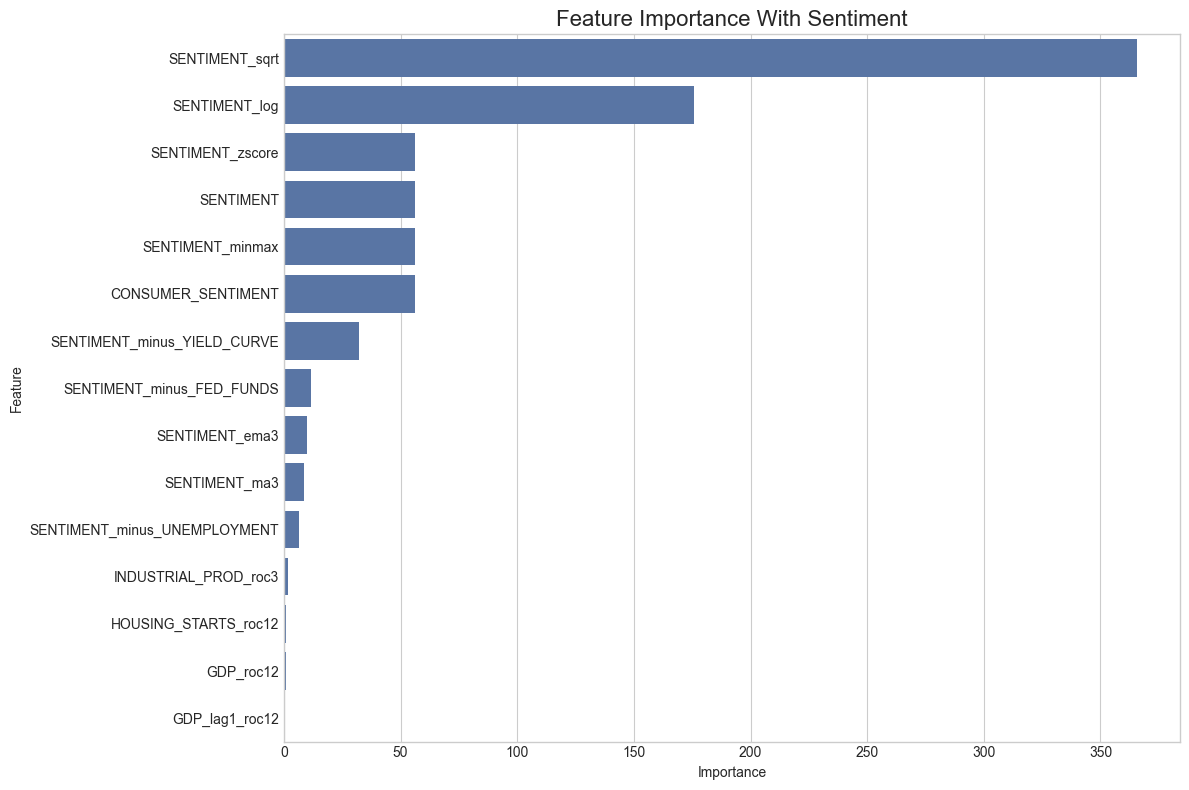

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\feature_importance_with_sentiment.png


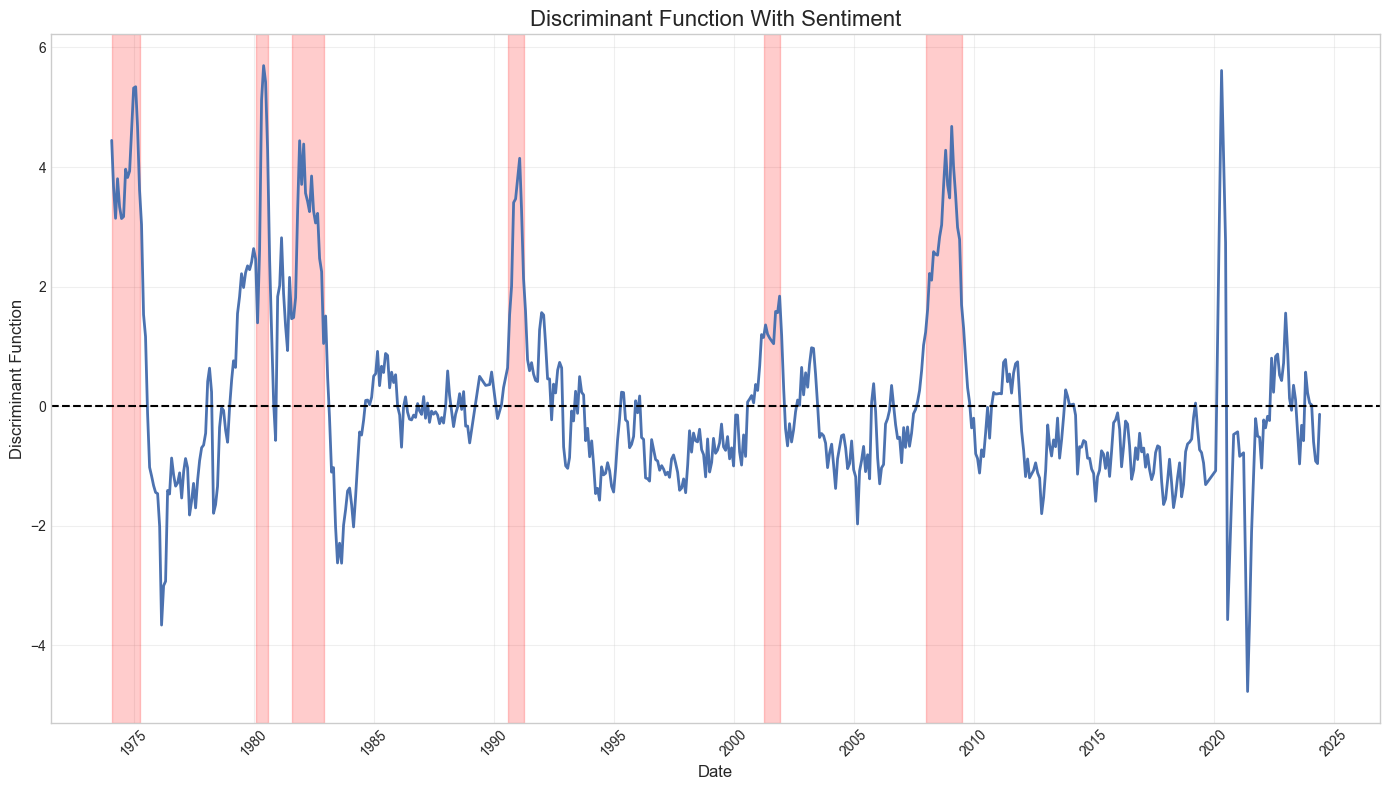

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\discriminant_time_series_with_sentiment.png

MDA Model with RFE-Selected Features:
2025-07-06 13:43:36,032 - econ_downturn.features.normalization - INFO - Normalized data using standard method, shape: (581, 21)
2025-07-06 13:43:36,037 - econ_downturn.models.mda - INFO - Training set shape: (406, 20), Testing set shape: (175, 20)
2025-07-06 13:43:36,047 - econ_downturn.models.mda - INFO - Accuracy: 0.9600
2025-07-06 13:43:36,048 - econ_downturn.models.mda - INFO - Confusion Matrix:
[[149   5]
 [  2  19]]
2025-07-06 13:43:36,049 - econ_downturn.models.mda - INFO - Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       154
         1.0       0.79      0.90      0.84        21

    accuracy                           0.96       175
   macro avg       0.89      0.94   

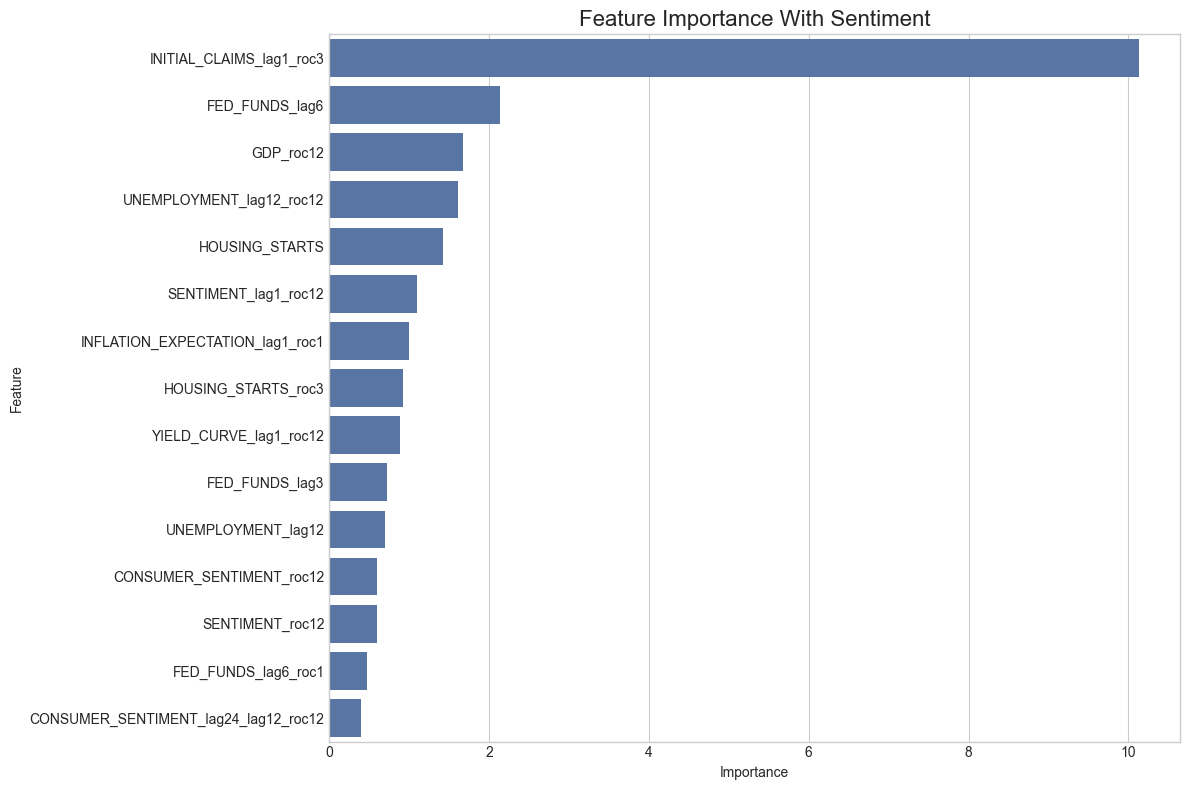

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\feature_importance_with_sentiment.png


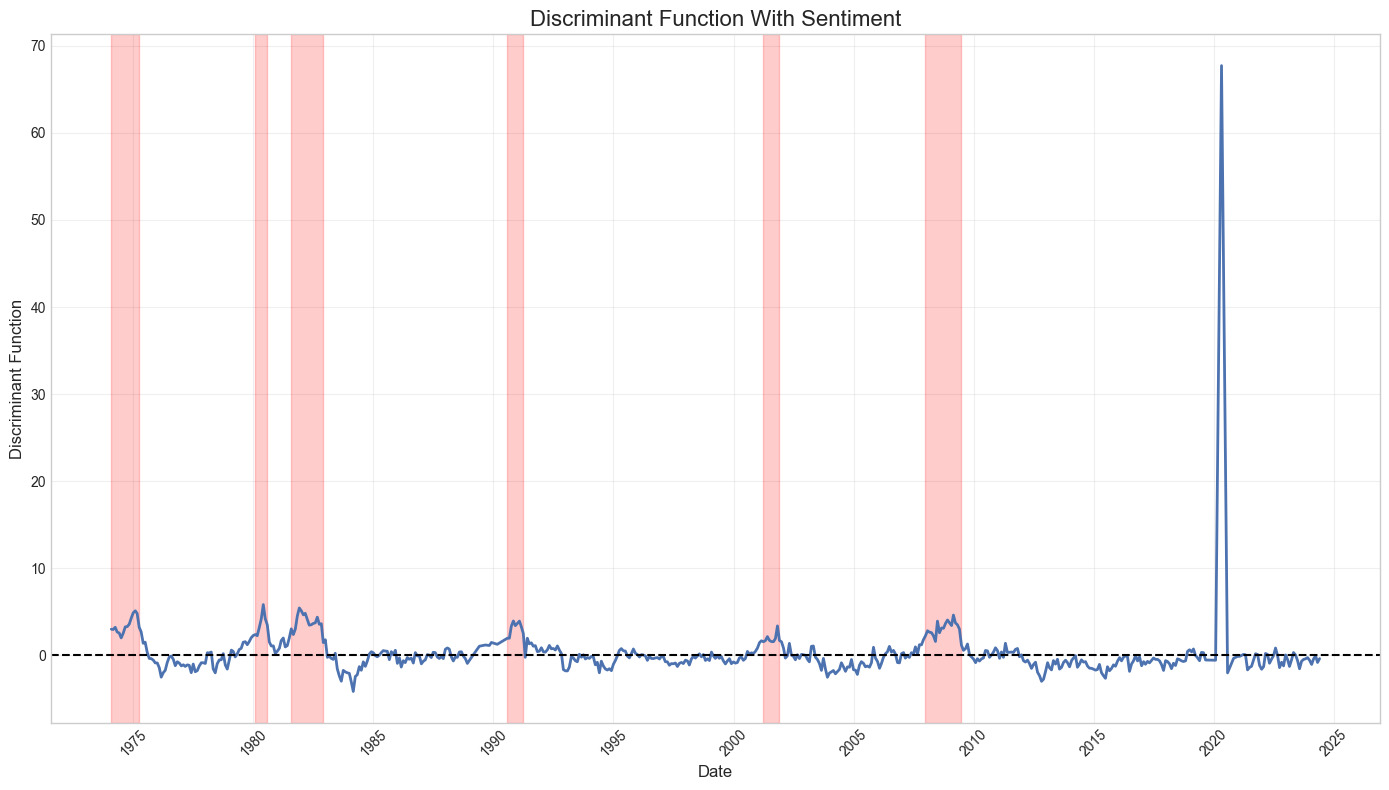

Saved figure to c:\Users\Admin\economic-downturn-detector\Copy of Economic Downturn\economic-downturn-detector\matt-version-downturn-detector\docs/images\discriminant_time_series_with_sentiment.png


In [8]:
# Add recession indicator to selected features
X_selected_anova_with_target = X_selected_anova.copy()
X_selected_anova_with_target['recession'] = y

X_selected_rfe_with_target = X_selected_rfe.copy()
X_selected_rfe_with_target['recession'] = y

# Apply MDA to ANOVA-selected features
print("\nMDA Model with ANOVA-Selected Features:")
mda_anova = compare_mda_models(X_selected_anova_with_target, with_sentiment=True)

# Apply MDA to RFE-selected features
print("\nMDA Model with RFE-Selected Features:")
mda_rfe = compare_mda_models(X_selected_rfe_with_target, with_sentiment=True)